Import packages

In [19]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics.cluster import adjusted_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

Loading and preprocessing data

In [20]:
data_path = 'https://raw.githubusercontent.com/dienthaipham103/programming_test/master/data/gateway.csv'

# read csv file
df = pd.read_csv(data_path)
# convert timestamp -> microseconds
df['timestamp'] = df['timestamp'].apply(lambda x: int(x.split(' ')[0])/(10**3))
df

,timestamp,gateway_targeted,succeeded,price,side,quantity
0,1.813080e+02,6,False,20000,sell,89
1,3.584480e+02,3,False,19999,sell,38
2,4.760810e+02,2,False,19999,buy,17
3,1.007773e+03,2,False,19999,buy,88
4,1.554167e+03,7,False,19999,buy,42
...,...,...,...,...,...,...
499995,2.500072e+08,7,False,18668,buy,58
499996,2.500081e+08,7,False,18666,sell,49
499997,2.500088e+08,6,False,18666,buy,92
499998,2.500095e+08,8,False,18665,sell,87


-------------------------------------------------------------------------------

**1. Does the data suggest that any particular gateway or gateways are faster than others?**

To identify the gateways that are faster than others, we analyze the time interval between two consecutive orders in each gateway.

In [21]:
# list all gateways
gateway_list = list(df['gateway_targeted'].unique())
sorted(gateway_list)

[1, 2, 3, 4, 5, 6, 7, 8]

In [22]:
# for each gateway, there is a list of time interval. We compute mean of the time intervals and compare the mean of all gateways
time_intervals = []
for gateway_num in gateway_list:
  df_sub = df[df['gateway_targeted'] == gateway_num].reset_index(drop=True)
  df_sub['dtime'] = df_sub['timestamp'] - df_sub['timestamp'].shift(1)
  X = df_sub['dtime'].to_numpy()[1:]
  time_intervals.append((gateway_num, X))

# show the mean of time intervals of all gateways
time_intervals.sort(key=lambda x: x[1].mean())
for gateway_num, X in time_intervals:
  print('Gateway %d: %f' %(gateway_num, X.mean()))

# save time_interval list of the gateways into a dictionary
time_intervals_dict = dict(time_intervals)

Gateway 6: 3981.345859
Gateway 4: 3986.079185
Gateway 2: 3991.136864
Gateway 8: 3999.060895
Gateway 3: 4003.408481
Gateway 5: 4006.887212
Gateway 7: 4014.491985
Gateway 1: 4018.686001


Conclude: Gateway 6, 4, 2, 8 are a little faster than gateway 3, 5, 7, 1

**2.	If you were asked to model the statistical significance of your results, how would you approach this? Note that “statistical significance” here doesn’t necessarily imply a frequentist approach; a Bayesian approach would be fine too.**

For each gateway, there is a list of time intervals between two consecutive orders. We can consider the list is a sample from a whole population of time intervals. Suppose that we have two gateways and want to know which gateway is faster, the thing we can do is to compare the population means of the time intervals of these two gateways. So, the Hypothesis Test for a Difference in Two Population Means could be used here to solve the problem.

Implementation of Hypothesis Test for a Difference in Two Population Means

In [23]:
'''
Suppose that we have two samples from different populations (different gateways)
The null hypothesis - H0: μ1 = μ2.
The alternative hypothesis - Ha: μ1 > μ2.
'''

# function to compute the sample standard deviation
def sample_std(X):
    sample_mean = X.mean()
    n = X.shape[0]
    s = math.sqrt(((X - sample_mean)**2).sum()/(n-1))
    return s

# function to compute the degrees of freedom
def degree_freedom(s1, s2, n1, n2):
    se1 = s1/math.sqrt(n1)
    se2 = s2/math.sqrt(n2)
    return (((se1)**2 + (se2)**2)**2)/((se1)**4/(n1-1) + (se2)**4/(n2-1))

# convert t-score into P-value. In this case, we use Right-tailed test (because Ha: u1 > u2)
def get_p_value(t_score, df):
    return scipy.stats.t.sf(t_score, df=df)

# input two samples, significance level -> Reject the null hypothesis or not
def hypothesis_test(X1, X2, significance_level=0.05):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    sample_mean1 = X1.mean()
    sample_mean2 = X2.mean()
    s1 = sample_std(X1)
    s2 = sample_std(X2)

    t_score = (sample_mean1 - sample_mean2)/math.sqrt(s1**2/n1 + s2**2/n2)
    df = degree_freedom(s1, s2, n1, n2)
    p_value = get_p_value(t_score, df)

    # show the info and the result
    print('Size of sample 1: ', n1)
    print('Size of sample 2: ', n2)
    print('P-value: ', p_value)
    print('Conclusion: ', ' Reject H0 and accept Ha' if p_value < significance_level else 'Accept H0')

In [24]:
'''
For example, we want to compare the speed of gateway 1 and 6. As the result of question 1, gateway 6 is faster than gateway 1 (u1 > u6)
Now, we will use the Hypothesis Test to check the result
'''
X_gateway1 = time_intervals_dict[1]
X_gateway6 = time_intervals_dict[6]
hypothesis_test(X_gateway1, X_gateway6)

Size of sample 1:  62211
Size of sample 2:  62795
P-value:  0.042670459361608376
Conclusion:   Reject H0 and accept Ha


Result: Accept Ha ------> u1 > u6
------> Gateway 6 is faster than gateway 1.

In [25]:
'''
Similarly, we can compare the speed of gateway 1 and gateway 7. We expect that gateway 7 is not faster than gateway 1 (u1 = u7, not u1 > u7)
'''
X_gateway7 = time_intervals_dict[7]
X_gateway1 = time_intervals_dict[1]
hypothesis_test(X_gateway1, X_gateway7)

Size of sample 1:  62211
Size of sample 2:  62276
P-value:  0.42337515252347785
Conclusion:  Accept H0


Result: Accept H0 ------> u1 = u7 -------> Gateway 7 and 1 almost have the same speed.

**3.	Bonus (optional, hard) question: from the data, can you determine any other factors affecting the probability of an order succeeding, other than the gateway?**

In [26]:
'''
This function is to compute the the percentage of succeeded orders based on feature (gateway, price, side, quanity)
'''
def percentage_success(df, feature):
  df_succeed = df.groupby(feature)['succeeded'].apply(lambda x: (x==True).sum()).reset_index(name='count')
  df_fail = df.groupby(feature)['succeeded'].apply(lambda x: (x==False).sum()).reset_index(name='count')

  df_percentage = pd.merge(df_succeed, df_fail, on=feature)
  df_percentage['succeed_percentage'] = df_percentage['count_x']/(df_percentage['count_x'] + df_percentage['count_y'])*100
  df_percentage = df_percentage[[feature, 'succeed_percentage']].sort_values(by='succeed_percentage', ascending=False).reset_index(drop=True)
  df_percentage = df_percentage.sort_values(by=feature).reset_index(drop=True)
  
  return df_percentage

a. Gateway

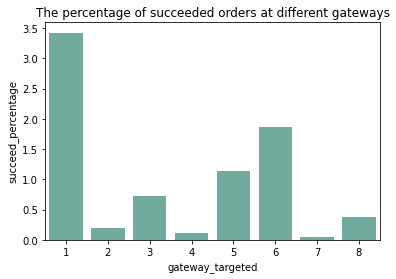

In [27]:
# Ananlyse the percentage of succeeded orders at different gateways
df_gateway = percentage_success(df, 'gateway_targeted')
# plot a bar chart to show the percentage
sns.barplot(
    x='gateway_targeted', 
    y='succeed_percentage', 
    data=df_gateway, 
    color='#69b3a2')
plt.title('The percentage of succeeded orders at different gateways')
plt.show()

b. Side

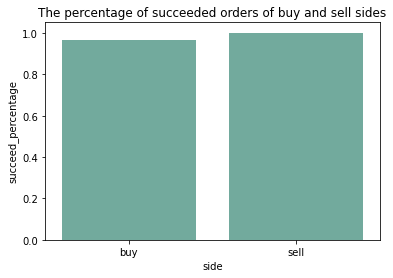

In [28]:
# Ananlyse the percentage of succeeded orders of sell and buy sides
df_side = percentage_success(df, 'side')
# plot a bar chart to show the percentage
sns.barplot(x='side', y='succeed_percentage', data=df_side, color='#69b3a2')
plt.title('The percentage of succeeded orders of buy and sell sides')
plt.show()

c. Price

In [29]:
# Check the minimum and maximum price
price_list = list(df['price'].unique())
min_price, max_price = min(price_list), max(price_list)
print('Min price: ', min_price)
print('Max price: ', max_price)

Min price:  18539
Max price:  20801


We divide the price into multiple ranges:
- range_1: 18539 -> 19000
- range_2: 19000 -> 19500
- range_3: 19500 -> 20000
- range_4: 20000 -> 20500
- range_5: 20500 -> 20801

In [30]:
def price_range(p):
  if p < 19000:
    return 1
  elif p < 19500:
    return 2
  elif p < 20000:
    return 3
  elif p < 20500:
    return 4
  else:
    return 5

df['price_range'] = df['price'].apply(price_range)
df

,timestamp,gateway_targeted,succeeded,price,side,quantity,price_range
0,1.813080e+02,6,False,20000,sell,89,4
1,3.584480e+02,3,False,19999,sell,38,3
2,4.760810e+02,2,False,19999,buy,17,3
3,1.007773e+03,2,False,19999,buy,88,3
4,1.554167e+03,7,False,19999,buy,42,3
...,...,...,...,...,...,...,...
499995,2.500072e+08,7,False,18668,buy,58,1
499996,2.500081e+08,7,False,18666,sell,49,1
499997,2.500088e+08,6,False,18666,buy,92,1
499998,2.500095e+08,8,False,18665,sell,87,1


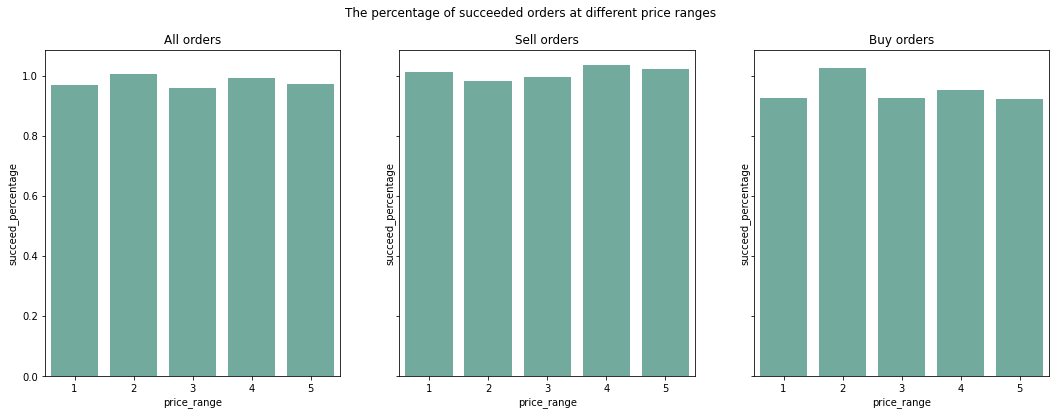

In [31]:
'''
Ananlyse the percentage of succeeded orders at different price ranges (for all orders, sell orders and buy orders)
'''

# Generate dataframe of percentage of succeeded orders
df_price = percentage_success(df, 'price_range')
df_sell = df[df['side'] == 'sell']
df_price_sell = percentage_success(df_sell, 'price_range')
df_buy = df[df['side'] == 'buy']
df_price_buy = percentage_success(df_buy, 'price_range')

# Draw plot
f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6))
f.suptitle('The percentage of succeeded orders at different price ranges')

axes[0].set_title('All orders')
axes[1].set_title('Sell orders')
axes[2].set_title('Buy orders')

sns.barplot(x='price_range', y='succeed_percentage', data=df_price, color='#69b3a2', ax=axes[0])
sns.barplot(x='price_range', y='succeed_percentage', data=df_price_sell, color='#69b3a2', ax=axes[1]) 
sns.barplot(x='price_range', y='succeed_percentage', data=df_price_buy, color='#69b3a2', ax=axes[2])

plt.show()

d. Quantity

In [32]:
# check the minimum and maximum quantity
quantity_list = list(df['quantity'].unique())
min_quantity, max_quantity = min(quantity_list), max(quantity_list)
print('Min quantity: ', min_quantity)
print('Max quantity: ', max_quantity)

Min quantity:  1
Max quantity:  101


We divide the quantity into multiple ranges:
- range_1: 1 -> 10
- range_2: 10 -> 20
- range_3: 20 -> 30
- range_4: 30 -> 40
- range_5: 40 -> 50
- range_6: 50 -> 60
- range_7: 60 -> 70
- range_8: 70 -> 80
- range_9: 80 -> 90
- range_10: 90 -> 101

In [33]:
def quantity_range(x):
  if x <= 90:
    return math.ceil(x/10)
  else:
    return 10

df['quantity_range'] = df['quantity'].apply(quantity_range)
df

,timestamp,gateway_targeted,succeeded,price,side,quantity,price_range,quantity_range
0,1.813080e+02,6,False,20000,sell,89,4,9
1,3.584480e+02,3,False,19999,sell,38,3,4
2,4.760810e+02,2,False,19999,buy,17,3,2
3,1.007773e+03,2,False,19999,buy,88,3,9
4,1.554167e+03,7,False,19999,buy,42,3,5
...,...,...,...,...,...,...,...,...
499995,2.500072e+08,7,False,18668,buy,58,1,6
499996,2.500081e+08,7,False,18666,sell,49,1,5
499997,2.500088e+08,6,False,18666,buy,92,1,10
499998,2.500095e+08,8,False,18665,sell,87,1,9


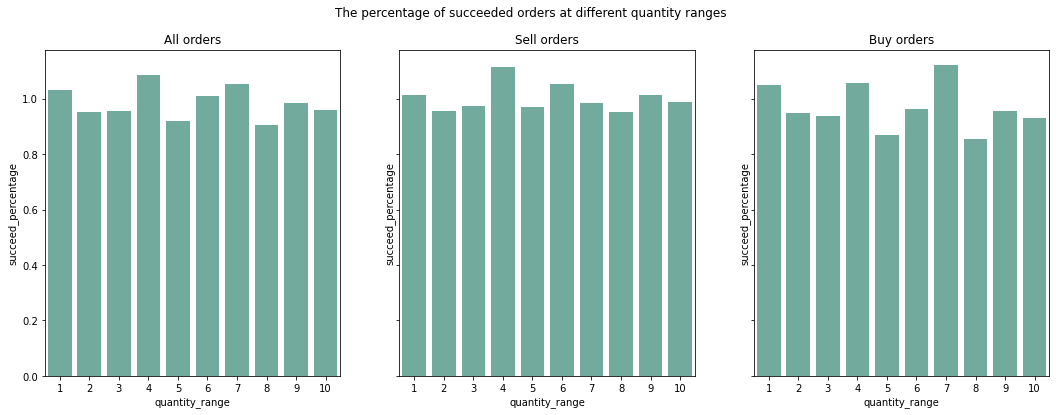

In [34]:
'''
Ananlyse the percentage of succeeded orders at different quantity ranges (for all orders, sell orders and buy orders)
'''

# Generate dataframe of percentage of succeeded orders
df_quantity = percentage_success(df, 'quantity_range')
df_sell = df[df['side'] == 'sell']
df_quantity_sell = percentage_success(df_sell, 'quantity_range')
df_buy = df[df['side'] == 'buy']
df_quantity_buy = percentage_success(df_buy, 'quantity_range')

# Draw plot
f, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6))
f.suptitle('The percentage of succeeded orders at different quantity ranges')

axes[0].set_title('All orders')
axes[1].set_title('Sell orders')
axes[2].set_title('Buy orders')

sns.barplot(x='quantity_range', y='succeed_percentage', data=df_quantity, color='#69b3a2', ax=axes[0])
sns.barplot(x='quantity_range', y='succeed_percentage', data=df_quantity_sell, color='#69b3a2', ax=axes[1]) 
sns.barplot(x='quantity_range', y='succeed_percentage', data=df_quantity_buy, color='#69b3a2', ax=axes[2])


plt.show()

notes:

Conclude: Based on the analyzing and visualization above, it's easy to see that only gateway impacts the probability of an order succeeding. The impact of other factors is trivial.

Questions:

1. Part 2: If you were asked to model the statistical significance of your results, I would use the Hypothesis Test for a Difference in Two Population Means.
        Please implemnent your idea in dev. 

2. Part 3c: why do you think splitting 5 ranges making sense?
3. Part 3: Please combine different features or using features engineering technique to see if there is any relevancy. Do note that the price sent for buy/sell will have great impact to the succeeding. For example, if you are sending buy order with low price, nobody is willing to sell to you and vice versa. It should have some relevancy. 



----------------------------------------------------------------------------

**Answer the extra questions**

**1.** I already implemented my approach above (In Question 2 part).

**2. Part 3c: why do you think splitting 5 ranges making sense?**

My purpose of splitting price into multiple ranges is to compute the percentage of succeeded orders in these ranges. As you analysed, the buy orders with high price will have high chance to succeed and vice versa. The sell orders with low price will also have high change to succeed and vice versa. So, the graph showing the percentage of succeeded orders at different price ranges (for sell and buy orders) should look like:

![](https://raw.githubusercontent.com/dienthaipham103/programming_test/master/data/price_impact.jpg)

If the dataset follows the rule you say, the shape of the graphs are not changed if I change the number of price ranges. Moreover, if the price of orders affects the probability of an order succeeding, the succeed_percentage will vary a lot among different price ranges.

Unfortunately, my graphs does not follow any specific rule. I think that there are two reasons. First, I am not sure that all orders are from stocks of one company or many companies. If the stocks are from many companies, the price of orders can not be compared to each other. Second, although the data is quiet large, but it is not large enough. The number of failed orders is still small. This dataset can not represent the entire population. The number of failed/succeeded orders, % of success (based on price ranges) is shown as following:

For sell orders:
- range_1 (18539 -> 19000): 508/49669 (1.01%)
- range_2 (19000 -> 19500): 965/97338 (0.98%)
- range_3 (19500 -> 20000): 340/33875 (0.99%)
- range_4 (20000 -> 20500): 391/37417 (1.03%)
- range_5 (20500 -> 20801): 305/29543 (1.02%)

For buy orders:
- range_1 (18539 -> 19000): 470/50322 (0.93%)
- range_2 (19000 -> 19500): 1003/96788 (1.03%)
- range_3 (19500 -> 20000): 313/33501 (0.93%)
- range_4 (20000 -> 20500): 357/37210 (0.95%)
- range_5 (20500 -> 20801): 274/29411 (0.92%)


**Part 3: Please combine different features or using features engineering technique to see if there is any relevancy. Do note that the price sent for buy/sell will have great impact to the succeeding. For example, if you are sending buy order with low price, nobody is willing to sell to you and vice versa. It should have some relevancy.**

I will use the feature importance score to analyze the effect of the fearures on target variable (success/fail).



In [35]:
'''
Prepare data to fit the ML model, compute the feature importance score
'''
df_new = df.copy()
df_new['gateway_targeted'] = df_new['gateway_targeted'].astype(str)
df_new['succeeded'] = df_new['succeeded'].astype(int)
df_new = df_new[['gateway_targeted', 'succeeded', 'price', 'side', 'quantity']]

# Convert categorical variables (Gateway_target, Side) to dummy variables
df_new = pd.get_dummies(df_new)

# Normalize two numerical variables (price, quantity). To scale all variables: 0 -> 1
df_new['price']=(df_new['price']-df_new['price'].min())/(df_new['price'].max()-df_new['price'].min())
df_new['quantity']=(df_new['quantity']-df_new['quantity'].min())/(df_new['quantity'].max()-df_new['quantity'].min())
df_new

,succeeded,price,quantity,gateway_targeted_1,gateway_targeted_2,gateway_targeted_3,gateway_targeted_4,gateway_targeted_5,gateway_targeted_6,gateway_targeted_7,gateway_targeted_8,side_buy,side_sell
0,0,0.645889,0.88,0,0,0,0,0,1,0,0,0,1
1,0,0.645447,0.37,0,0,1,0,0,0,0,0,0,1
2,0,0.645447,0.16,0,1,0,0,0,0,0,0,1,0
3,0,0.645447,0.87,0,1,0,0,0,0,0,0,1,0
4,0,0.645447,0.41,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0.057029,0.57,0,0,0,0,0,0,1,0,1,0
499996,0,0.056145,0.48,0,0,0,0,0,0,1,0,0,1
499997,0,0.056145,0.91,0,0,0,0,0,1,0,0,1,0
499998,0,0.055703,0.86,0,0,0,0,0,0,0,1,0,1


In [36]:
X = np.array(df_new.drop(['succeeded'], axis=1))
y = np.array(df_new['succeeded'])
print('Number of features: ', X.shape[1])

Number of features:  12


There are 12 features. The first two features are related to price, quantity. The last two features are related to side (sell/buy) 

Feature: 0, Score: -0.01781
Feature: 1, Score: -0.04692
Feature: 2, Score: 2.00752
Feature: 3, Score: -0.85976
Feature: 4, Score: 0.43287
Feature: 5, Score: -1.36155
Feature: 6, Score: 0.88228
Feature: 7, Score: 1.38020
Feature: 8, Score: -2.24871
Feature: 9, Score: -0.23086
Feature: 10, Score: -0.01395
Feature: 11, Score: 0.01593


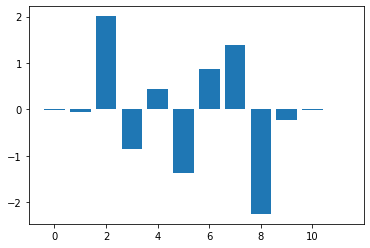

In [37]:
'''
Now, I fit a LogisticRegression model on the dataset and retrieve the coefficients for each input variable.
These coefficients can provide the basis for a feature importance score.
The coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, 
whereas the negative scores indicate a feature that predicts class 0.
The coefficients of features that are not important tend to be 0.
'''

# Define the model
model = LogisticRegression()

# Fit the model
model.fit(X, y)

# Get importance
importance = model.coef_[0]

# Summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Conclusion: The importance score of the first two features and the last two feature tend to be 0. So, features related to price, quantity and side do no effect much on the succeeding of orders. For the score of features related to gateway, it absolutely match with the result of percentage of succeeded orders with different gateways.

![](https://raw.githubusercontent.com/dienthaipham103/programming_test/master/data/gateway_impact.png)

For example:
- Gateway 1: The percentage of success is highest. So, the coefficient of this features is positive and it is also the highest.
- Gateway 7: The percentage of success is lowest. So, the coefficient of this features is negative and it is also the lowest.

Feature: 0, Score: 0.00271
Feature: 1, Score: 0.00217
Feature: 2, Score: 0.34172
Feature: 3, Score: 0.03784
Feature: 4, Score: 0.02369
Feature: 5, Score: 0.05507
Feature: 6, Score: 0.19160
Feature: 7, Score: 0.26626
Feature: 8, Score: 0.06318
Feature: 9, Score: 0.01438
Feature: 10, Score: 0.00137
Feature: 11, Score: 0.00000


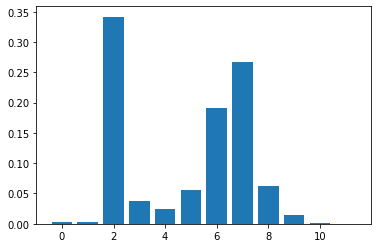

In [38]:
'''
Logistic regression does not support imbalanced classification (Our dataset is so imbalanced). For this reason, the result of feature importance may be
not very accurate.
So, I do the same way but with XGBoost model. This algorithm can handle imbalanced dataset directly.
'''

# Define the model. Handle imbalanced data by scale_pos_weight = 495074/4926 = 100
model = XGBClassifier(scale_pos_weight=100)

# Fit the model
model.fit(X, y)

# Get importance
importance = model.feature_importances_

# Summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

The result is still the same. The importance score of features related to price, quantity and side also tend to 0. 

-----------------------------------------------------------------

In [39]:
'''
Compute the correlation between price and succeeded
'''

# for all orders
corr = df_new['price'].corr(df_new['succeeded'])
print("Correlation between price and succeeded (all orders): ", corr)

# for sell orders
df_new_sell = df_new[df_new['side_sell'] == 1]
corr1 = df_new_sell['price'].corr(df_new_sell['succeeded'])
print("Correlation between price and succeeded (sell orders): ", corr1)

# for buy orders
df_new_buy = df_new[df_new['side_buy'] == 1]
corr2 = df_new_buy['price'].corr(df_new_buy['succeeded'])
print("Correlation between price and succeeded (buy orders): ", corr2)

Correlation between price and succeeded (all orders):  -0.00024873727633607784
Correlation between price and succeeded (sell orders):  0.0011055065033043615
Correlation between price and succeeded (buy orders):  -0.0016356586990338739


There appears to be not a strong correlation between the price and succeeded.

-----------------------------------------------

I also want to try another way to compute the feature importance score by using the Adjusted Mutual Information (AMI) [paper](https://jmlr.csail.mit.edu/papers/volume11/vinh10a/vinh10a.pdf), a metric for scoring features in unsupervised learning.

In [40]:
ami_list = []
for feature in df_new.columns:
    if feature != 'succeeded':
        ami_list.append((feature, adjusted_mutual_info_score(df_new['succeeded'], df_new[feature])))
ami_list.sort(key=lambda x: abs(x[1]), reverse=True)

# show AMI of all features
for feature, ami in ami_list:
    print(feature)
    print('AMI: {:.6f}'.format(ami))
    print('---------------------')

gateway_targeted_1
AMI: 0.013572
---------------------
gateway_targeted_7
AMI: 0.004978
---------------------
gateway_targeted_4
AMI: 0.003878
---------------------
gateway_targeted_2
AMI: 0.002971
---------------------
gateway_targeted_6
AMI: 0.002133
---------------------
gateway_targeted_8
AMI: 0.001589
---------------------
gateway_targeted_3
AMI: 0.000237
---------------------
gateway_targeted_5
AMI: 0.000071
---------------------
price
AMI: -0.000021
---------------------
quantity
AMI: 0.000012
---------------------
side_buy
AMI: 0.000001
---------------------
side_sell
AMI: 0.000001
---------------------
